<a href="https://colab.research.google.com/github/gbdionne/toneclone/blob/main/spectrogramCNN_alt8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir /content/final_datasets

!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/final_real.h5" "/content/final_datasets/final_real.h5"
#!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/final_real.csv" "/content/final_datasets/final_real.csv"
!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/Copy of full_real_test_w_DSP_features.csv" "/content/final_datasets/final_real.csv"

!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/test_extra_TRM_DLY.h5" "/content/final_datasets/test_extra_TRM_DLY.h5"
#!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/test_extra_TRM_DLY.csv" "/content/final_datasets/test_extra_TRM_DLY.csv"
!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/Copy of full_test_w_DSP_features.csv" "/content/final_datasets/final_test.csv"

!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/validate_extra_TRM_DLY.h5" "/content/final_datasets/validate_extra_TRM_DLY.h5"
#!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/validate_extra_TRM_DLY.csv" "/content/final_datasets/validate_extra_TRM_DLY.csv"
!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/Copy of full_validate_w_DSP_features.csv" "/content/final_datasets/final_validate.csv"

!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/train_extra_TRM_DLY.h5" "/content/final_datasets/train_extra_TRM_DLY.h5"
#!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/train_extra_TRM_DLY.csv" "/content/final_datasets/train_extra_TRM_DLY.csv"
!cp "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/Copy of full_train_w_DSP_features.csv" "/content/final_datasets/final_train.csv"

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import h5py
import pandas as pd
from sklearn.metrics import classification_report
import torchaudio.transforms as T
import random
import warnings

warnings.filterwarnings("ignore", message="Downcasting object dtype arrays on .fillna")

class SpectrogramDataset(Dataset):
    """
    Custom dataset for spectrogram data with data augmentation.
    Includes:
    - Random Gaussian noise
    - Pitch shifting using torch.roll() with zero-padding (prevents wrapping)
    """

    def __init__(self, hdf5_file, csv_file, augment=True, noise_level=0.03, pitch_shift_range=(-0.5, 0.5)):
        """
        Args:
            hdf5_file (str): Path to the HDF5 file containing spectrograms.
            csv_file (str): Path to CSV file with labels.
            augment (bool): Whether to apply data augmentation.
            noise_level (float): Standard deviation of Gaussian noise to add.
            pitch_shift_range (tuple): Min/max semitones for pitch shifting.
        """
        self.hdf5_file_path = hdf5_file
        self.data = pd.read_csv(csv_file)

        # Manually define only important columns
        self.label_map = [
            'overdrive', 'distortion', 'fuzz', 'tremolo', 'phaser',
            'flanger', 'chorus', 'delay', 'hall_reverb', 'plate_reverb',
            'octaver', 'auto_filter'
        ]

        # Extract DSP feature columns
        self.dsp_features = self.data.drop(columns=['key'] + self.label_map)

        # Check for NaN or Inf values and replace them
        if self.dsp_features.isna().sum().sum() > 0:
            print("Warning: NaN values found in DSP features. Replacing with 0.")
            self.dsp_features = self.dsp_features.fillna(0)

        if np.isinf(self.dsp_features.values).sum() > 0:
            print("Warning: Inf values found in DSP features. Replacing with large finite numbers.")
            self.dsp_features = np.nan_to_num(self.dsp_features)

        # Normalize DSP features
        self.dsp_features = (self.dsp_features - self.dsp_features.mean()) / (self.dsp_features.std() + 1e-8)

        self.hdf5_file = None  # Open HDF5 file once per worker

        self.augment = augment
        self.noise_level = noise_level
        self.pitch_shift_range = pitch_shift_range

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Open HDF5 file per worker to avoid threading issues
        if self.hdf5_file is None:
            self.hdf5_file = h5py.File(self.hdf5_file_path, "r", swmr=True)

        # Retrieve spectrogram
        key = self.data.iloc[idx]['key']
        spectrogram = torch.tensor(self.hdf5_file[key][()], dtype=torch.float32).unsqueeze(0)

        # Retrieve labels
        label_values = self.data.iloc[idx][self.label_map].fillna(0).astype(float).values
        label = torch.tensor(label_values, dtype=torch.float32)

        # Retrieve DSP features
        dsp_features = torch.tensor(self.dsp_features.iloc[idx].values, dtype=torch.float32)

        # Data augmentation
        if self.augment:
            spectrogram = self.add_noise(spectrogram)
            spectrogram = self.pitch_shift(spectrogram)

        return spectrogram, dsp_features, label

    def add_noise(self, spectrogram):
        """Adds Gaussian noise where noise level is randomly chosen between 0 and self.noise_level."""
        noise_level = random.uniform(0, self.noise_level)  # Random noise per sample
        noise = torch.randn_like(spectrogram) * noise_level  # Scale noise
        return spectrogram + noise

    def pitch_shift(self, spectrogram):
        """Shifts spectrogram frequency bins using torch.roll() with zero padding."""
        semitone_shift = random.uniform(*self.pitch_shift_range)  # Random shift between min/max
        shift_bins = int(semitone_shift / 12 * spectrogram.shape[-2])  # Convert semitone shift to frequency bins

        # Apply frequency bin shift using torch.roll() with zero-padding
        shifted = torch.roll(spectrogram, shifts=shift_bins, dims=-2)  # Shift along frequency axis

        if shift_bins > 0:  # Shift up (higher pitch)
            shifted[..., :shift_bins, :] = 0  # Zero-pad low frequencies
        elif shift_bins < 0:  # Shift down (lower pitch)
            shifted[..., shift_bins:, :] = 0  # Zero-pad high frequencies

        return shifted

    def __del__(self):
        if self.hdf5_file is not None:
            self.hdf5_file.close()

In [12]:
class spectrogramCNN(nn.Module):
    def __init__(self, num_classes, dsp_feature_dim):
        super(spectrogramCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer for CNN output
        self.cnn_fc = nn.Linear(512, 256)

        # Fully connected layer for DSP features
        self.dsp_fc = nn.Linear(dsp_feature_dim, 64)

        # Combined fully connected layers
        self.fc1 = nn.Linear(256 + 64, 256)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x, dsp_features):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # Max pooling

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.cnn_fc(x))

        # Process DSP features
        dsp_features = F.relu(self.dsp_fc(dsp_features))

        # Concatenate feature sets
        combined = torch.cat((x, dsp_features), dim=1)

        # Fully connected layers
        combined = F.relu(self.fc1(combined))
        combined = self.dropout(combined)
        combined = self.fc2(combined)

        return combined

In [13]:
# Initialize dataset from HD5F and csv file

h5_train_path = '/content/final_datasets/train_extra_TRM_DLY.h5'
csv_train_path = '/content/final_datasets/final_train.csv'

h5_val_path = '/content/final_datasets/validate_extra_TRM_DLY.h5'
csv_val_path = '/content/final_datasets/final_validate.csv'

model_save_path = "/content/drive/MyDrive/Capstone 210/Models/final_multi_effects_altX.mod"

train_dataset = SpectrogramDataset(h5_train_path, csv_train_path)
val_dataset = SpectrogramDataset(h5_val_path, csv_val_path)

In [14]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=6, pin_memory=True)

dsp_feature_dim = train_dataset.dsp_features.shape[1]
num_classes = len(train_dataset.label_map)

model = spectrogramCNN(num_classes, dsp_feature_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8577)  # 0.0001 → 0.00001 over 15 epochs
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)

train_losses = []
val_losses = []

# Training loop
num_epochs = 15
print_freq = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (spectrograms, dsp_features, labels) in enumerate(train_loader):
        spectrograms, dsp_features, labels = spectrograms.to(device), dsp_features.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(spectrograms, dsp_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    # Update learning rate
    scheduler.step()
    print(f"Updated Learning Rate: {scheduler.get_last_lr()}")

    # Validation step
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for spectrograms, dsp_features, labels in val_loader:
            spectrograms, dsp_features, labels = spectrograms.to(device), dsp_features.to(device), labels.to(device)
            outputs = model(spectrograms, dsp_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions

            # Store for metric computation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Convert lists to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    # Print classification report
    class_names = train_dataset.label_map
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print(f"\nValidation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")

    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

Epoch [1/15], Batch [50/4502], Loss: 0.3509
Epoch [1/15], Batch [100/4502], Loss: 0.3537
Epoch [1/15], Batch [150/4502], Loss: 0.2984
Epoch [1/15], Batch [200/4502], Loss: 0.2247
Epoch [1/15], Batch [250/4502], Loss: 0.2331
Epoch [1/15], Batch [300/4502], Loss: 0.1884
Epoch [1/15], Batch [350/4502], Loss: 0.1454
Epoch [1/15], Batch [400/4502], Loss: 0.1396
Epoch [1/15], Batch [450/4502], Loss: 0.1283
Epoch [1/15], Batch [500/4502], Loss: 0.1304
Epoch [1/15], Batch [550/4502], Loss: 0.1395
Epoch [1/15], Batch [600/4502], Loss: 0.1343
Epoch [1/15], Batch [650/4502], Loss: 0.1205
Epoch [1/15], Batch [700/4502], Loss: 0.1008
Epoch [1/15], Batch [750/4502], Loss: 0.0891
Epoch [1/15], Batch [800/4502], Loss: 0.1230
Epoch [1/15], Batch [850/4502], Loss: 0.1490
Epoch [1/15], Batch [900/4502], Loss: 0.1078
Epoch [1/15], Batch [950/4502], Loss: 0.0738
Epoch [1/15], Batch [1000/4502], Loss: 0.0786
Epoch [1/15], Batch [1050/4502], Loss: 0.0974
Epoch [1/15], Batch [1100/4502], Loss: 0.0850
Epoch [1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/15], Batch [50/4502], Loss: 0.0428
Epoch [2/15], Batch [100/4502], Loss: 0.0373
Epoch [2/15], Batch [150/4502], Loss: 0.0158
Epoch [2/15], Batch [200/4502], Loss: 0.0164
Epoch [2/15], Batch [250/4502], Loss: 0.0669
Epoch [2/15], Batch [300/4502], Loss: 0.0183
Epoch [2/15], Batch [350/4502], Loss: 0.0283
Epoch [2/15], Batch [400/4502], Loss: 0.0108
Epoch [2/15], Batch [450/4502], Loss: 0.0345
Epoch [2/15], Batch [500/4502], Loss: 0.0305
Epoch [2/15], Batch [550/4502], Loss: 0.0144
Epoch [2/15], Batch [600/4502], Loss: 0.0494
Epoch [2/15], Batch [650/4502], Loss: 0.0220
Epoch [2/15], Batch [700/4502], Loss: 0.0162
Epoch [2/15], Batch [750/4502], Loss: 0.0271
Epoch [2/15], Batch [800/4502], Loss: 0.0551
Epoch [2/15], Batch [850/4502], Loss: 0.0271
Epoch [2/15], Batch [900/4502], Loss: 0.0304
Epoch [2/15], Batch [950/4502], Loss: 0.0231
Epoch [2/15], Batch [1000/4502], Loss: 0.0226
Epoch [2/15], Batch [1050/4502], Loss: 0.0291
Epoch [2/15], Batch [1100/4502], Loss: 0.0112
Epoch [2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/15], Batch [50/4502], Loss: 0.0057
Epoch [3/15], Batch [100/4502], Loss: 0.0189
Epoch [3/15], Batch [150/4502], Loss: 0.0175
Epoch [3/15], Batch [200/4502], Loss: 0.0126
Epoch [3/15], Batch [250/4502], Loss: 0.0136
Epoch [3/15], Batch [300/4502], Loss: 0.0152
Epoch [3/15], Batch [350/4502], Loss: 0.0097
Epoch [3/15], Batch [400/4502], Loss: 0.0041
Epoch [3/15], Batch [450/4502], Loss: 0.0148
Epoch [3/15], Batch [500/4502], Loss: 0.0117
Epoch [3/15], Batch [550/4502], Loss: 0.0062
Epoch [3/15], Batch [600/4502], Loss: 0.0107
Epoch [3/15], Batch [650/4502], Loss: 0.0091
Epoch [3/15], Batch [700/4502], Loss: 0.0134
Epoch [3/15], Batch [750/4502], Loss: 0.0081
Epoch [3/15], Batch [800/4502], Loss: 0.0049
Epoch [3/15], Batch [850/4502], Loss: 0.0177
Epoch [3/15], Batch [900/4502], Loss: 0.0067
Epoch [3/15], Batch [950/4502], Loss: 0.0079
Epoch [3/15], Batch [1000/4502], Loss: 0.0037
Epoch [3/15], Batch [1050/4502], Loss: 0.0187
Epoch [3/15], Batch [1100/4502], Loss: 0.0083
Epoch [3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/15], Batch [50/4502], Loss: 0.0146
Epoch [4/15], Batch [100/4502], Loss: 0.0162
Epoch [4/15], Batch [150/4502], Loss: 0.0063
Epoch [4/15], Batch [200/4502], Loss: 0.0071
Epoch [4/15], Batch [250/4502], Loss: 0.0248
Epoch [4/15], Batch [300/4502], Loss: 0.0042
Epoch [4/15], Batch [350/4502], Loss: 0.0116
Epoch [4/15], Batch [400/4502], Loss: 0.0113
Epoch [4/15], Batch [450/4502], Loss: 0.0291
Epoch [4/15], Batch [500/4502], Loss: 0.0028
Epoch [4/15], Batch [550/4502], Loss: 0.0065
Epoch [4/15], Batch [600/4502], Loss: 0.0023
Epoch [4/15], Batch [650/4502], Loss: 0.0075
Epoch [4/15], Batch [700/4502], Loss: 0.0021
Epoch [4/15], Batch [750/4502], Loss: 0.0048
Epoch [4/15], Batch [800/4502], Loss: 0.0013
Epoch [4/15], Batch [850/4502], Loss: 0.0078
Epoch [4/15], Batch [900/4502], Loss: 0.0042
Epoch [4/15], Batch [950/4502], Loss: 0.0101
Epoch [4/15], Batch [1000/4502], Loss: 0.0242
Epoch [4/15], Batch [1050/4502], Loss: 0.0054
Epoch [4/15], Batch [1100/4502], Loss: 0.0034
Epoch [4

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/15], Batch [50/4502], Loss: 0.0209
Epoch [5/15], Batch [100/4502], Loss: 0.0030
Epoch [5/15], Batch [150/4502], Loss: 0.0207
Epoch [5/15], Batch [200/4502], Loss: 0.0313
Epoch [5/15], Batch [250/4502], Loss: 0.0025
Epoch [5/15], Batch [300/4502], Loss: 0.0023
Epoch [5/15], Batch [350/4502], Loss: 0.0195
Epoch [5/15], Batch [400/4502], Loss: 0.0072
Epoch [5/15], Batch [450/4502], Loss: 0.0030
Epoch [5/15], Batch [500/4502], Loss: 0.0262
Epoch [5/15], Batch [550/4502], Loss: 0.0128
Epoch [5/15], Batch [600/4502], Loss: 0.0052
Epoch [5/15], Batch [650/4502], Loss: 0.0199
Epoch [5/15], Batch [700/4502], Loss: 0.0079
Epoch [5/15], Batch [750/4502], Loss: 0.0092
Epoch [5/15], Batch [800/4502], Loss: 0.0041
Epoch [5/15], Batch [850/4502], Loss: 0.0010
Epoch [5/15], Batch [900/4502], Loss: 0.0226
Epoch [5/15], Batch [950/4502], Loss: 0.0021
Epoch [5/15], Batch [1000/4502], Loss: 0.0011
Epoch [5/15], Batch [1050/4502], Loss: 0.0038
Epoch [5/15], Batch [1100/4502], Loss: 0.0010
Epoch [5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/15], Batch [50/4502], Loss: 0.0028
Epoch [6/15], Batch [100/4502], Loss: 0.0043
Epoch [6/15], Batch [150/4502], Loss: 0.0075
Epoch [6/15], Batch [200/4502], Loss: 0.0037
Epoch [6/15], Batch [250/4502], Loss: 0.0188
Epoch [6/15], Batch [300/4502], Loss: 0.0029
Epoch [6/15], Batch [350/4502], Loss: 0.0030
Epoch [6/15], Batch [400/4502], Loss: 0.0122
Epoch [6/15], Batch [450/4502], Loss: 0.0004
Epoch [6/15], Batch [500/4502], Loss: 0.0022
Epoch [6/15], Batch [550/4502], Loss: 0.0008
Epoch [6/15], Batch [600/4502], Loss: 0.0048
Epoch [6/15], Batch [650/4502], Loss: 0.0022
Epoch [6/15], Batch [700/4502], Loss: 0.0275
Epoch [6/15], Batch [750/4502], Loss: 0.0035
Epoch [6/15], Batch [800/4502], Loss: 0.0051
Epoch [6/15], Batch [850/4502], Loss: 0.0178
Epoch [6/15], Batch [900/4502], Loss: 0.0079
Epoch [6/15], Batch [950/4502], Loss: 0.0058
Epoch [6/15], Batch [1000/4502], Loss: 0.0103
Epoch [6/15], Batch [1050/4502], Loss: 0.0013
Epoch [6/15], Batch [1100/4502], Loss: 0.0018
Epoch [6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/15], Batch [50/4502], Loss: 0.0009
Epoch [7/15], Batch [100/4502], Loss: 0.0052
Epoch [7/15], Batch [150/4502], Loss: 0.0018
Epoch [7/15], Batch [200/4502], Loss: 0.0002
Epoch [7/15], Batch [250/4502], Loss: 0.0065
Epoch [7/15], Batch [300/4502], Loss: 0.0026
Epoch [7/15], Batch [350/4502], Loss: 0.0037
Epoch [7/15], Batch [400/4502], Loss: 0.0011
Epoch [7/15], Batch [450/4502], Loss: 0.0018
Epoch [7/15], Batch [500/4502], Loss: 0.0021
Epoch [7/15], Batch [550/4502], Loss: 0.0031
Epoch [7/15], Batch [600/4502], Loss: 0.0088
Epoch [7/15], Batch [650/4502], Loss: 0.0005
Epoch [7/15], Batch [700/4502], Loss: 0.0013
Epoch [7/15], Batch [750/4502], Loss: 0.0048
Epoch [7/15], Batch [800/4502], Loss: 0.0025
Epoch [7/15], Batch [850/4502], Loss: 0.0005
Epoch [7/15], Batch [900/4502], Loss: 0.0031
Epoch [7/15], Batch [950/4502], Loss: 0.0078
Epoch [7/15], Batch [1000/4502], Loss: 0.0173
Epoch [7/15], Batch [1050/4502], Loss: 0.0026
Epoch [7/15], Batch [1100/4502], Loss: 0.0101
Epoch [7

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/15], Batch [50/4502], Loss: 0.0058
Epoch [8/15], Batch [100/4502], Loss: 0.0010
Epoch [8/15], Batch [150/4502], Loss: 0.0154
Epoch [8/15], Batch [200/4502], Loss: 0.0041
Epoch [8/15], Batch [250/4502], Loss: 0.0123
Epoch [8/15], Batch [300/4502], Loss: 0.0041
Epoch [8/15], Batch [350/4502], Loss: 0.0036
Epoch [8/15], Batch [400/4502], Loss: 0.0016
Epoch [8/15], Batch [450/4502], Loss: 0.0002
Epoch [8/15], Batch [500/4502], Loss: 0.0010
Epoch [8/15], Batch [550/4502], Loss: 0.0012
Epoch [8/15], Batch [600/4502], Loss: 0.0003
Epoch [8/15], Batch [650/4502], Loss: 0.0038
Epoch [8/15], Batch [700/4502], Loss: 0.0037
Epoch [8/15], Batch [750/4502], Loss: 0.0017
Epoch [8/15], Batch [800/4502], Loss: 0.0005
Epoch [8/15], Batch [850/4502], Loss: 0.0005
Epoch [8/15], Batch [900/4502], Loss: 0.0009
Epoch [8/15], Batch [950/4502], Loss: 0.0034
Epoch [8/15], Batch [1000/4502], Loss: 0.0077
Epoch [8/15], Batch [1050/4502], Loss: 0.0003
Epoch [8/15], Batch [1100/4502], Loss: 0.0031
Epoch [8

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/15], Batch [50/4502], Loss: 0.0141
Epoch [9/15], Batch [100/4502], Loss: 0.0014
Epoch [9/15], Batch [150/4502], Loss: 0.0118
Epoch [9/15], Batch [200/4502], Loss: 0.0004
Epoch [9/15], Batch [250/4502], Loss: 0.0053
Epoch [9/15], Batch [300/4502], Loss: 0.0075
Epoch [9/15], Batch [350/4502], Loss: 0.0083
Epoch [9/15], Batch [400/4502], Loss: 0.0004
Epoch [9/15], Batch [450/4502], Loss: 0.0007
Epoch [9/15], Batch [500/4502], Loss: 0.0001
Epoch [9/15], Batch [550/4502], Loss: 0.0031
Epoch [9/15], Batch [600/4502], Loss: 0.0089
Epoch [9/15], Batch [650/4502], Loss: 0.0007
Epoch [9/15], Batch [700/4502], Loss: 0.0010
Epoch [9/15], Batch [750/4502], Loss: 0.0008
Epoch [9/15], Batch [800/4502], Loss: 0.0014
Epoch [9/15], Batch [850/4502], Loss: 0.0006
Epoch [9/15], Batch [900/4502], Loss: 0.0011
Epoch [9/15], Batch [950/4502], Loss: 0.0005
Epoch [9/15], Batch [1000/4502], Loss: 0.0001
Epoch [9/15], Batch [1050/4502], Loss: 0.0002
Epoch [9/15], Batch [1100/4502], Loss: 0.0020
Epoch [9

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/15], Batch [50/4502], Loss: 0.0031
Epoch [10/15], Batch [100/4502], Loss: 0.0053
Epoch [10/15], Batch [150/4502], Loss: 0.0057
Epoch [10/15], Batch [200/4502], Loss: 0.0023
Epoch [10/15], Batch [250/4502], Loss: 0.0020
Epoch [10/15], Batch [300/4502], Loss: 0.0010
Epoch [10/15], Batch [350/4502], Loss: 0.0004
Epoch [10/15], Batch [400/4502], Loss: 0.0063
Epoch [10/15], Batch [450/4502], Loss: 0.0001
Epoch [10/15], Batch [500/4502], Loss: 0.0012
Epoch [10/15], Batch [550/4502], Loss: 0.0087
Epoch [10/15], Batch [600/4502], Loss: 0.0012
Epoch [10/15], Batch [650/4502], Loss: 0.0039
Epoch [10/15], Batch [700/4502], Loss: 0.0050
Epoch [10/15], Batch [750/4502], Loss: 0.0007
Epoch [10/15], Batch [800/4502], Loss: 0.0004
Epoch [10/15], Batch [850/4502], Loss: 0.0004
Epoch [10/15], Batch [900/4502], Loss: 0.0004
Epoch [10/15], Batch [950/4502], Loss: 0.0002
Epoch [10/15], Batch [1000/4502], Loss: 0.0002
Epoch [10/15], Batch [1050/4502], Loss: 0.0096
Epoch [10/15], Batch [1100/4502],

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [11/15], Batch [50/4502], Loss: 0.0006
Epoch [11/15], Batch [100/4502], Loss: 0.0005
Epoch [11/15], Batch [150/4502], Loss: 0.0022
Epoch [11/15], Batch [200/4502], Loss: 0.0040
Epoch [11/15], Batch [250/4502], Loss: 0.0004
Epoch [11/15], Batch [300/4502], Loss: 0.0007
Epoch [11/15], Batch [350/4502], Loss: 0.0006
Epoch [11/15], Batch [400/4502], Loss: 0.0005
Epoch [11/15], Batch [450/4502], Loss: 0.0001
Epoch [11/15], Batch [500/4502], Loss: 0.0003
Epoch [11/15], Batch [550/4502], Loss: 0.0006
Epoch [11/15], Batch [600/4502], Loss: 0.0032
Epoch [11/15], Batch [650/4502], Loss: 0.0012
Epoch [11/15], Batch [700/4502], Loss: 0.0026
Epoch [11/15], Batch [750/4502], Loss: 0.0010
Epoch [11/15], Batch [800/4502], Loss: 0.0003
Epoch [11/15], Batch [850/4502], Loss: 0.0021
Epoch [11/15], Batch [900/4502], Loss: 0.0006
Epoch [11/15], Batch [950/4502], Loss: 0.0084
Epoch [11/15], Batch [1000/4502], Loss: 0.0022
Epoch [11/15], Batch [1050/4502], Loss: 0.0004
Epoch [11/15], Batch [1100/4502],

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [12/15], Batch [50/4502], Loss: 0.0069
Epoch [12/15], Batch [100/4502], Loss: 0.0025
Epoch [12/15], Batch [150/4502], Loss: 0.0024
Epoch [12/15], Batch [200/4502], Loss: 0.0015
Epoch [12/15], Batch [250/4502], Loss: 0.0001
Epoch [12/15], Batch [300/4502], Loss: 0.0016
Epoch [12/15], Batch [350/4502], Loss: 0.0004
Epoch [12/15], Batch [400/4502], Loss: 0.0009
Epoch [12/15], Batch [450/4502], Loss: 0.0010
Epoch [12/15], Batch [500/4502], Loss: 0.0074
Epoch [12/15], Batch [550/4502], Loss: 0.0012
Epoch [12/15], Batch [600/4502], Loss: 0.0003
Epoch [12/15], Batch [650/4502], Loss: 0.0122
Epoch [12/15], Batch [700/4502], Loss: 0.0000
Epoch [12/15], Batch [750/4502], Loss: 0.0100
Epoch [12/15], Batch [800/4502], Loss: 0.0013
Epoch [12/15], Batch [850/4502], Loss: 0.0001
Epoch [12/15], Batch [900/4502], Loss: 0.0163
Epoch [12/15], Batch [950/4502], Loss: 0.0016
Epoch [12/15], Batch [1000/4502], Loss: 0.0003
Epoch [12/15], Batch [1050/4502], Loss: 0.0002
Epoch [12/15], Batch [1100/4502],

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [13/15], Batch [50/4502], Loss: 0.0022
Epoch [13/15], Batch [100/4502], Loss: 0.0015
Epoch [13/15], Batch [150/4502], Loss: 0.0028
Epoch [13/15], Batch [200/4502], Loss: 0.0007
Epoch [13/15], Batch [250/4502], Loss: 0.0008
Epoch [13/15], Batch [300/4502], Loss: 0.0104
Epoch [13/15], Batch [350/4502], Loss: 0.0009
Epoch [13/15], Batch [400/4502], Loss: 0.0001
Epoch [13/15], Batch [450/4502], Loss: 0.0005
Epoch [13/15], Batch [500/4502], Loss: 0.0004
Epoch [13/15], Batch [550/4502], Loss: 0.0011
Epoch [13/15], Batch [600/4502], Loss: 0.0002
Epoch [13/15], Batch [650/4502], Loss: 0.0010
Epoch [13/15], Batch [700/4502], Loss: 0.0002
Epoch [13/15], Batch [750/4502], Loss: 0.0004
Epoch [13/15], Batch [800/4502], Loss: 0.0024
Epoch [13/15], Batch [850/4502], Loss: 0.0023
Epoch [13/15], Batch [900/4502], Loss: 0.0010
Epoch [13/15], Batch [950/4502], Loss: 0.0016
Epoch [13/15], Batch [1000/4502], Loss: 0.0001
Epoch [13/15], Batch [1050/4502], Loss: 0.0120
Epoch [13/15], Batch [1100/4502],

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [14/15], Batch [50/4502], Loss: 0.0003
Epoch [14/15], Batch [100/4502], Loss: 0.0007
Epoch [14/15], Batch [150/4502], Loss: 0.0013
Epoch [14/15], Batch [200/4502], Loss: 0.0092
Epoch [14/15], Batch [250/4502], Loss: 0.0013
Epoch [14/15], Batch [300/4502], Loss: 0.0001
Epoch [14/15], Batch [350/4502], Loss: 0.0001
Epoch [14/15], Batch [400/4502], Loss: 0.0005
Epoch [14/15], Batch [450/4502], Loss: 0.0144
Epoch [14/15], Batch [500/4502], Loss: 0.0001
Epoch [14/15], Batch [550/4502], Loss: 0.0006
Epoch [14/15], Batch [600/4502], Loss: 0.0061
Epoch [14/15], Batch [650/4502], Loss: 0.0083
Epoch [14/15], Batch [700/4502], Loss: 0.0003
Epoch [14/15], Batch [750/4502], Loss: 0.0002
Epoch [14/15], Batch [800/4502], Loss: 0.0002
Epoch [14/15], Batch [850/4502], Loss: 0.0059
Epoch [14/15], Batch [900/4502], Loss: 0.0003
Epoch [14/15], Batch [950/4502], Loss: 0.0002
Epoch [14/15], Batch [1000/4502], Loss: 0.0013
Epoch [14/15], Batch [1050/4502], Loss: 0.0011
Epoch [14/15], Batch [1100/4502],

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [15/15], Batch [50/4502], Loss: 0.0007
Epoch [15/15], Batch [100/4502], Loss: 0.0004
Epoch [15/15], Batch [150/4502], Loss: 0.0001
Epoch [15/15], Batch [200/4502], Loss: 0.0007
Epoch [15/15], Batch [250/4502], Loss: 0.0010
Epoch [15/15], Batch [300/4502], Loss: 0.0012
Epoch [15/15], Batch [350/4502], Loss: 0.0047
Epoch [15/15], Batch [400/4502], Loss: 0.0020
Epoch [15/15], Batch [450/4502], Loss: 0.0003
Epoch [15/15], Batch [500/4502], Loss: 0.0002
Epoch [15/15], Batch [550/4502], Loss: 0.0002
Epoch [15/15], Batch [600/4502], Loss: 0.0104
Epoch [15/15], Batch [650/4502], Loss: 0.0022
Epoch [15/15], Batch [700/4502], Loss: 0.0003
Epoch [15/15], Batch [750/4502], Loss: 0.0015
Epoch [15/15], Batch [800/4502], Loss: 0.0012
Epoch [15/15], Batch [850/4502], Loss: 0.0005
Epoch [15/15], Batch [900/4502], Loss: 0.0041
Epoch [15/15], Batch [950/4502], Loss: 0.0007
Epoch [15/15], Batch [1000/4502], Loss: 0.0001
Epoch [15/15], Batch [1050/4502], Loss: 0.0029
Epoch [15/15], Batch [1100/4502],

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


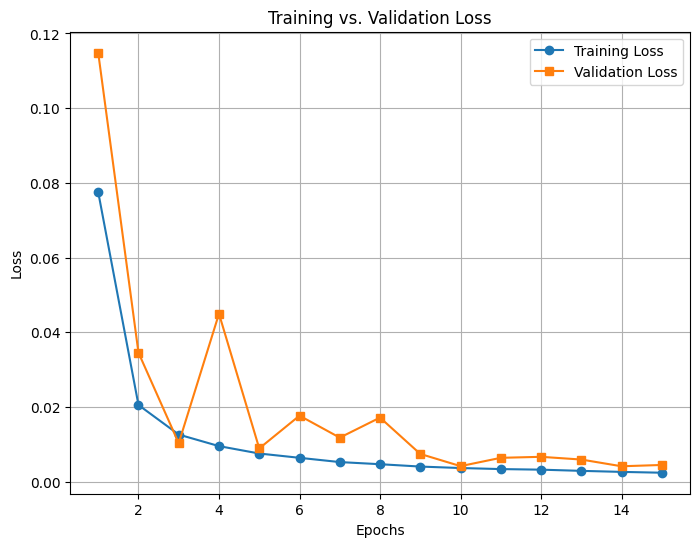

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load test dataset
h5_test_path = "/content/final_datasets/test_extra_TRM_DLY.h5"
csv_test_path = "/content/final_datasets/final_test.csv"

model_load_path = "/content/drive/MyDrive/Capstone 210/Models/final_multi_effects_altX.mod"

test_dataset = SpectrogramDataset(h5_test_path, csv_test_path)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)

num_classes = len(test_dataset.label_map)
dsp_feature_dim = train_dataset.dsp_features.shape[1]

# Load a saved model for test dataset metrics
model = spectrogramCNN(num_classes, dsp_feature_dim).to(device)
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()
print("Model loaded successfully.")

print("\nEvaluating with external test dataset...")

model.eval()
criterion = nn.BCEWithLogitsLoss()
test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for spectrograms, dsp_features, labels in test_loader:
        spectrograms, dsp_features, labels = spectrograms.to(device), dsp_features.to(device), labels.to(device)
        outputs = model(spectrograms, dsp_features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert logits to binary predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)

# Compute test metrics
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average="macro", zero_division=0)
test_recall = recall_score(test_labels, test_preds, average="macro", zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average="macro", zero_division=0)

print(f"\nTest Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}\n")

# Print classification report
class_names = test_dataset.label_map
print(classification_report(test_labels, test_preds, target_names=class_names))

Model loaded successfully.

Evaluating with external test dataset...


KeyError: Caught KeyError in DataLoader worker process 10.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "<ipython-input-11-74b1d14380c9>", line 75, in __getitem__
    spectrogram = torch.tensor(self.hdf5_file[key][()], dtype=torch.float32).unsqueeze(0)
                               ~~~~~~~~~~~~~~^^^^^
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/usr/local/lib/python3.11/dist-packages/h5py/_hl/group.py", line 357, in __getitem__
    oid = h5o.open(self.id, self._e(name), lapl=self._lapl)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5o.pyx", line 257, in h5py.h5o.open
KeyError: "Unable to synchronously open object (object 'final_validate_DLY_180ms.wav_seg_1' doesn't exist)"


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load test dataset
# h5_test_path = "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/final_real.h5"
# csv_test_path = "/content/drive/MyDrive/Capstone 210/Data/Final Datasets/final_real.csv"

h5_test_path = "/content/final_datasets/final_real.h5"
csv_test_path = "/content/final_datasets/final_real.csv"

model_load_path = "/content/drive/MyDrive/Capstone 210/Models/final_multi_effects_altX.mod"

test_dataset = SpectrogramDataset(h5_test_path, csv_test_path)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)

dsp_feature_dim = test_dataset.dsp_features.shape[1]
num_classes = len(test_dataset.label_map)

# Load a saved model for test dataset metrics
model = spectrogramCNN(num_classes, dsp_feature_dim).to(device)
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()
print("Model loaded successfully.")

print("\nEvaluating with external test dataset...")

model.eval()
criterion = nn.BCEWithLogitsLoss()
test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for spectrograms, dsp_features, labels in test_loader:
        spectrograms, dsp_features, labels = spectrograms.to(device), dsp_features.to(device), labels.to(device)
        outputs = model(spectrograms, dsp_features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert logits to binary predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)

# Compute test metrics
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average="macro", zero_division=0)
test_recall = recall_score(test_labels, test_preds, average="macro", zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average="macro", zero_division=0)

print(f"\nTest Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}\n")

# Print classification report
class_names = test_dataset.label_map
print(classification_report(test_labels, test_preds, target_names=class_names))

Model loaded successfully.

Evaluating with external test dataset...

Test Loss: 0.1079, Accuracy: 0.7873, Precision: 0.8930, Recall: 0.9310, F1-score: 0.9055

              precision    recall  f1-score   support

   overdrive       0.75      0.86      0.80      3432
  distortion       0.99      0.98      0.98      5148
        fuzz       1.00      0.95      0.97      6006
     tremolo       0.84      0.98      0.90      4290
      phaser       1.00      0.92      0.96      5148
     flanger       0.99      0.76      0.86      3432
      chorus       0.92      0.96      0.94      6006
       delay       0.95      0.94      0.94      7722
 hall_reverb       0.92      0.93      0.92      5148
plate_reverb       0.89      0.97      0.93      3432
     octaver       0.59      0.99      0.74      2574
 auto_filter       0.88      0.93      0.90      4290

   micro avg       0.90      0.93      0.92     56628
   macro avg       0.89      0.93      0.91     56628
weighted avg       0.91     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from google.colab import runtime
runtime.unassign()